In [0]:
import string
import nltk
import numpy as np
import torch.functional as F
import torch.nn.functional as F
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import torch
from torch.autograd import Variable
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [21]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
dataset = pd.read_csv('bbc-text.csv')
dataset.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [0]:
def preprocess_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

dataset_clean = pd.DataFrame(dataset.text.apply(lambda x: preprocess_text(x)))

In [24]:
dataset_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [25]:
corpus = dataset['text']
print(corpus)


0       tv future in the hands of viewers with home th...
1       worldcom boss  left books alone  former worldc...
2       tigers wary of farrell  gamble  leicester say ...
3       yeading face newcastle in fa cup premiership s...
4       ocean s twelve raids box office ocean s twelve...
                              ...                        
2220    cars pull down us retail figures us retail sal...
2221    kilroy unveils immigration policy ex-chatshow ...
2222    rem announce new glasgow concert us band rem h...
2223    how political squabbles snowball it s become c...
2224    souness delight at euro progress boss graeme s...
Name: text, Length: 2225, dtype: object


In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
tokenized_corpus = []
stemmer = PorterStemmer()
for i in range(len(corpus)):
    sentence = preprocess_text(corpus[i])
    tokenized_corpus.append(word_tokenize((sentence)))

In [28]:
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [30]:
word2idx

{'tv': 0,
 'future': 1,
 'hands': 2,
 'viewers': 3,
 'home': 4,
 'theatre': 5,
 'systems': 6,
 'plasma': 7,
 'highdefinition': 8,
 'tvs': 9,
 'digital': 10,
 'video': 11,
 'recorders': 12,
 'moving': 13,
 'living': 14,
 'room': 15,
 'way': 16,
 'people': 17,
 'watch': 18,
 'radically': 19,
 'different': 20,
 'five': 21,
 'years': 22,
 'time': 23,
 'according': 24,
 'expert': 25,
 'panel': 26,
 'gathered': 27,
 'annual': 28,
 'consumer': 29,
 'electronics': 30,
 'show': 31,
 'las': 32,
 'vegas': 33,
 'discuss': 34,
 'new': 35,
 'technologies': 36,
 'impact': 37,
 'one': 38,
 'favourite': 39,
 'pastimes': 40,
 'us': 41,
 'leading': 42,
 'trend': 43,
 'programmes': 44,
 'content': 45,
 'delivered': 46,
 'via': 47,
 'networks': 48,
 'cable': 49,
 'satellite': 50,
 'telecoms': 51,
 'companies': 52,
 'broadband': 53,
 'service': 54,
 'providers': 55,
 'front': 56,
 'rooms': 57,
 'portable': 58,
 'devices': 59,
 'talkedabout': 60,
 'ces': 61,
 'personal': 62,
 'dvr': 63,
 'pvr': 64,
 'settop'

In [0]:
window_size = 2
idx_pairs = []

for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word considered as the central word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # check window borders
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs)

In [0]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [0]:
embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 101
learning_rate = 0.001


In [0]:
for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
def lab1(word):
    index_of_word = -1
    for i in range(len(vocabulary)):
        if  (vocabulary[i] == word):
            index_of_word = i
    if (index_of_word < 0):
        print('This word does not exist on dataset')
    if (index_of_word >= 0):
        print('Index of the word', vocabulary[index_of_word],' is ',index_of_word)
        print('Task 1: Thensors of words')
        print(W2.data)
        cos_distance = []
        labels = []
        ta = np.array(W2.data)
        for j in range(len(W2)):
            result = np.dot(
                np.array(ta[j]),
                            np.array(ta[index_of_word]))
            /
            (((np.sum(ta[j]**2))**0.5) * ((np.sum(ta[index_of_word]**2))**0.5)
            )
            cos_distance.append([result, j])
        cos_distance_sorted = sorted(cos_distance, key=lambda x: x[0], reverse=True)
        for i in (range(10)):
            print(cos_distance_sorted[i], vocabulary[cos_distance_sorted[i][1]])
            labels.append(vocabulary[cos_distance_sorted[i][1]])
        array_for_dot_cloud = []
        array_for_dot_cloud_label = []
        for i in range(11):
            array_for_dot_cloud.append(np.array
                                       (ta[cos_distance_sorted[i][1]]))
            array_for_dot_cloud_label.append(vocabulary[cos_distance_sorted[i][1]])
        print(W2[cos_distance_sorted[i][1]], vocabulary[cos_distance_sorted[i][1]])
        array_for_dot_cloud = np.array(array_for_dot_cloud)
        print(array_for_dot_cloud)
        X_embedded = TSNE(n_components=2).fit_transform(array_for_dot_cloud)
        X_embedded.shape
        #print(X_embedded)
        x = []
        y = []
        new_values = X_embedded
        for value in new_values:
            x.append(value[0])
            y.append(value[1])
        plt.figure(figsize=(16, 16)) 
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(array_for_dot_cloud_label[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.show()

Index of the word france  is  3886
Task 1: Thensors of words
tensor([[-0.3394, -0.4784,  0.6607, -0.2633,  0.2366],
        [ 0.5933,  0.1231, -1.1471, -0.0629, -1.1420],
        [ 0.9265,  1.3105,  0.2721, -0.1728,  1.0614],
        ...,
        [ 0.6373, -1.2228,  0.1930,  0.0416, -0.1005],
        [-0.0607, -0.5845,  1.0401, -1.1766, -1.1655],
        [-1.1630,  0.0298,  0.1273, -2.4386,  1.0360]])
[12.095089, 9420] troy
[11.252786, 15858] waved
[10.987053, 29124] consensual
[10.81735, 19697] lonely
[10.745483, 10828] transparency
[10.652388, 29832] fairminded
[10.426286, 28989] timewarner
[10.400646, 22654] lomax
[10.396447, 12529] simulates
[10.36718, 24367] imparting
tensor([-1.4917, -1.0917, -1.3336,  0.7988, -2.5210], grad_fn=<SelectBackward>) yassir
[[-2.3323426   0.5651389  -0.93530697 -0.73745996 -3.337968  ]
 [-2.7392826  -1.5802501  -0.7102259   0.32541987 -2.2383668 ]
 [-0.78476554 -1.4710072  -1.3405707   0.17066468 -3.0781982 ]
 [-2.0471897  -0.16661334 -0.447567   -0.0

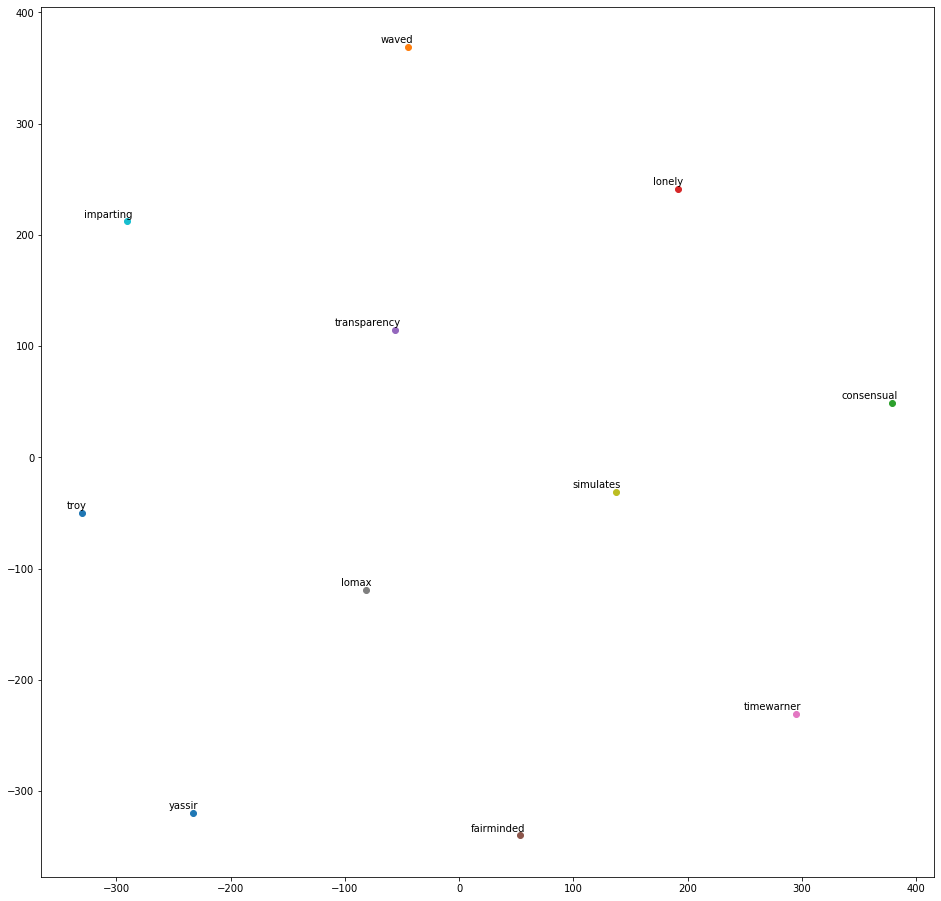

In [39]:
lab1('france')

Index of the word month  is  1926
Task 1: Thensors of words
tensor([[-0.3394, -0.4784,  0.6607, -0.2633,  0.2366],
        [ 0.5933,  0.1231, -1.1471, -0.0629, -1.1420],
        [ 0.9265,  1.3105,  0.2721, -0.1728,  1.0614],
        ...,
        [ 0.6373, -1.2228,  0.1930,  0.0416, -0.1005],
        [-0.0607, -0.5845,  1.0401, -1.1766, -1.1655],
        [-1.1630,  0.0298,  0.1273, -2.4386,  1.0360]])
[12.213242, 23669] aladdin
[11.93442, 21273] tributes
[11.213242, 10552] shading
[10.899458, 19578] saluted
[10.745337, 17586] aspiration
[10.696967, 12996] gogetter
[10.613855, 6869] combat
[10.509859, 19882] macy
[10.475587, 823] seven
[10.414774, 15212] negroponte
tensor([-1.4004, -2.7546,  0.6611,  1.7492, -0.0823], grad_fn=<SelectBackward>) phoned
[[-0.5851298  -1.6655858   1.2155302   3.3784485  -1.1445796 ]
 [-1.6010734  -2.7158082   0.65412444  2.0828495  -1.1431768 ]
 [ 0.58788705 -3.0412743  -0.8770154   2.2723832  -0.9939765 ]
 [ 1.3667747  -2.6112168  -0.43253335  2.878213   -0

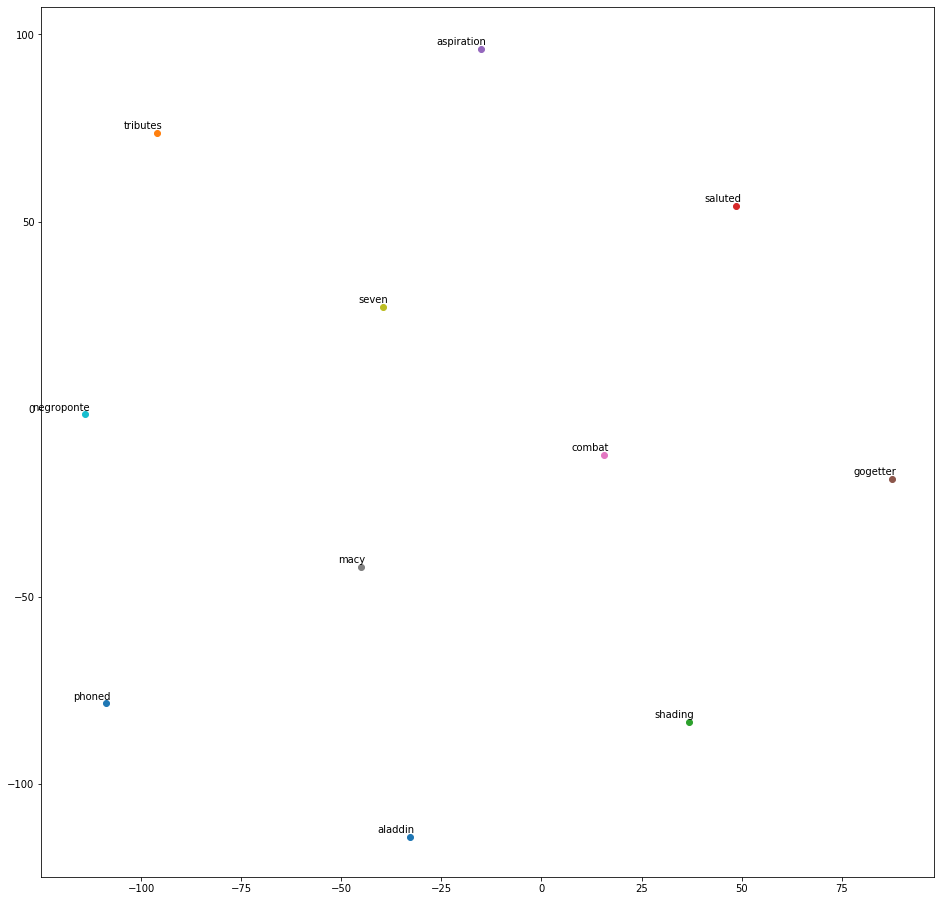

In [40]:
lab1('month')